# evaluating machine learning models

### split data into:
    1) training
    2) validation
    3) split

### hold-out valdiaiton

In [1]:
from keras.models import Sequential
from keras.layers import Dense
import numpy as np

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
x_data = np.random.rand(20000,100)*100
y_data = np.random.randint(0,2,size=(20000, 1))
data = np.hstack((x_data, y_data))

num_val_data = 3000

np.random.shuffle(data)

test_data = data[:num_val_data]
val_data = data[num_val_data:2*num_val_data]
train_data = data[2*num_val_data:]

def get_model():
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(100,)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    return model

get_model().fit(
    train_data[:,:100], train_data[:,-1],epochs=3,batch_size=1024,validation_data=(val_data[:,:100], val_data[:,-1]))

In [ ]:
#optimize model on validation set
#once hyperparams tuning done, join sets and train# the final model

data = np.concatenate((train_data, val_data))

get_model().fit(
    data[:,:100], data[:,-1], epochs=2, batch_size=1024, validation_data=(test_data[:,:100], test_data[:,-1]))

### k-fold + iterative k-fold validation

In [ ]:
x_data = np.random.rand(20000,100)*100
y_data = np.random.randint(0,2,size=(20000, 1))
data = np.hstack((x_data, y_data))

#setup k-disjoint sets for training/cross-validation
k = 5
hist_acc = []
num_val_data = data.shape[0] // k 

np.random.shuffle(data)

test_data = data[:num_val_data]
data = data[num_val_data:]

#evaluate k times
for i in range(k):
    print('K-fold #', i)
    val_data = data[i*num_val_data:(i+1)*num_val_data]
    train_data = np.concatenate((data[:i*num_val_data], data[(i+1)*num_val_data:]))
    
    hist = get_model().fit(
        train_data[:,:100], train_data[:,-1],epochs=1,batch_size=1024,validation_data=(val_data[:,:100], val_data[:,-1]))
    hist_acc.append(hist.history['acc'])

np.mean(hist_acc)

# under- & overfitting

### levarge network capacity (size)

In [2]:
from keras.datasets import imdb

In [3]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)

In [4]:
def vectorize_sequences(sequences, dim=10000):
    result = np.zeros((len(sequences), dim))
    for i, seq in enumerate(sequences):
        result[i, seq] = 1
    return result

In [5]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(25000,) (25000,)
(25000,) (25000,)


In [6]:
x_train = vectorize_sequences(x_train)
x_test = vectorize_sequences(x_test)

In [7]:
print(x_train.shape)
print(x_test.shape)

(25000, 10000)
(25000, 10000)


In [21]:
history = []

In [22]:
initial_model = Sequential()
initial_model.add(Dense(64, activation='relu', input_shape=(10000,)))
initial_model.add(Dense(64, activation='relu'))
initial_model.add(Dense(1, activation='sigmoid'))
initial_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

initial_hist = initial_model.fit(x_train, y_train, epochs=20, batch_size=512, validation_split=0.2, verbose=0)
print(initial_model.evaluate(x_test, y_test))

history.append(initial_hist.history)

25000/25000 [==============================] - 2s 74us/step
[1.001278562080264, 0.85264]


In [23]:
short_model = Sequential()
short_model.add(Dense(4, activation='relu', input_shape=(10000,)))
short_model.add(Dense(4, activation='relu'))
short_model.add(Dense(1, activation='sigmoid'))
short_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

short_hist = short_model.fit(x_train, y_train, epochs=20, batch_size=512,  validation_split=0.2,verbose=0)
print(short_model.evaluate(x_test, y_test))

history.append(short_hist.history)

25000/25000 [==============================] - 1s 46us/step
[0.46026311126947406, 0.86468]


In [24]:
big_model = Sequential()
big_model.add(Dense(512, activation='relu', input_shape=(10000,)))
big_model.add(Dense(512, activation='relu'))
big_model.add(Dense(1, activation='sigmoid'))
big_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

big_hist = big_model.fit(x_train, y_train, epochs=20, batch_size=512,  validation_split=0.2, verbose=0)
print(big_model.evaluate(x_test, y_test))

history.append(big_hist.history)

25000/25000 [==============================] - 3s 139us/step
[0.8832368401676416, 0.86856]


In [25]:
history[0].keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

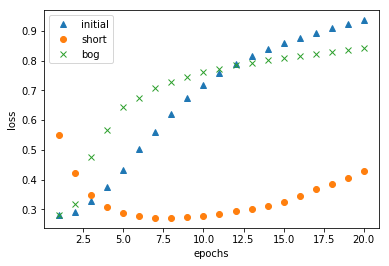

In [39]:
import matplotlib.pyplot as plt

epochs = range(1,21)

plt.plot(epochs, history[0]['val_loss'], '^', label="initial")
plt.plot(epochs, history[1]['val_loss'], 'o', label="short")
plt.plot(epochs, history[2]['val_loss'], 'x', label="bog")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

### L2 regulariation

In [27]:
from keras import regularizers

model_reg = Sequential()
model_reg.add(Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(10000,)))
model_reg.add(Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model_reg.add(Dense(1, activation='sigmoid'))
model_reg.compile(optimizer='adam', loss='binary_crossentropy',metrics=['acc'])

hist_reg = model_reg.fit(x_train, y_train, batch_size=512, epochs=20,  validation_split=0.2, verbose=0)

In [38]:
model_reg.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 57us/step


[0.5722689803791046, 0.85216]

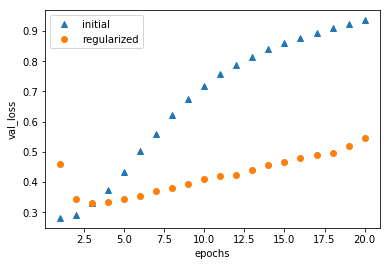

In [40]:
plt.plot(epochs, history[0]['val_loss'], '^', label="initial")
plt.plot(epochs, hist_reg.history['val_loss'], 'o', label="regularized")
plt.xlabel('epochs')
plt.ylabel('val_loss')
plt.legend()

plt.show()

### Dropout

In [31]:
from keras.layers import Dropout

In [35]:
model_drop = Sequential()
model_drop.add(Dense(16, activation='relu', input_shape=(10000,)))
model_drop.add(Dropout(0.8))
model_drop.add(Dense(16, activation='relu', input_shape=(10000,)))
model_drop.add(Dropout(0.8))
model_drop.add(Dense(1, activation='sigmoid'))

model_drop.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
hist_drop = model_drop.fit(x_train, y_train, batch_size=512, epochs=20, validation_split=0.2, verbose=0)

In [37]:
model_drop.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 54us/step


[0.37420669471740725, 0.87972]

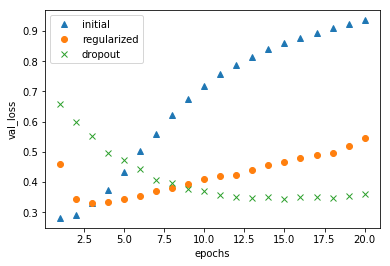

In [41]:
plt.plot(epochs, history[0]['val_loss'], '^', label="initial")
plt.plot(epochs, hist_reg.history['val_loss'], 'o', label="regularized")
plt.plot(epochs, hist_drop.history['val_loss'], 'x', label="dropout")
plt.xlabel('epochs')
plt.ylabel('val_loss')
plt.legend()

plt.show()